# Grokking Demo Notebook

# Setup
(No need to read)

In [1]:
# Janky code to do different setup when run in a Colab notebook vs VSCode
DEVELOPMENT_MODE = True
try:
    import google.colab
    IN_COLAB = True
    print("Running as a Colab notebook")
    %pip install git+https://github.com/neelnanda-io/TransformerLens.git@new-demo
    %pip install circuitsvis
    
    # PySvelte is an unmaintained visualization library, use it as a backup if circuitsvis isn't working
    # # Install another version of node that makes PySvelte work way faster
    # !curl -fsSL https://deb.nodesource.com/setup_16.x | sudo -E bash -; sudo apt-get install -y nodejs
    # %pip install git+https://github.com/neelnanda-io/PySvelte.git
except:
    IN_COLAB = False
    print("Running as a Jupyter notebook - intended for development only!")
    from IPython import get_ipython

    ipython = get_ipython()
    # Code to automatically update the HookedTransformer code as its edited without restarting the kernel
    ipython.magic("load_ext autoreload")
    ipython.magic("autoreload 2")

Running as a Jupyter notebook - intended for development only!


/var/folders/6s/zv4ygprx6jvg4d7jsgbjfc1r0000gn/T/ipykernel_4489/3667787199.py:21: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  ipython.magic("load_ext autoreload")
/var/folders/6s/zv4ygprx6jvg4d7jsgbjfc1r0000gn/T/ipykernel_4489/3667787199.py:22: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  ipython.magic("autoreload 2")


In [2]:
# Plotly needs a different renderer for VSCode/Notebooks vs Colab argh
import plotly.io as pio
if IN_COLAB or not DEVELOPMENT_MODE:
    pio.renderers.default = "colab"
else:
    pio.renderers.default = "notebook_connected"
print(f"Using renderer: {pio.renderers.default}")

Using renderer: notebook_connected


In [2]:
pio.templates['plotly'].layout.xaxis.title.font.size = 20
pio.templates['plotly'].layout.yaxis.title.font.size = 20
pio.templates['plotly'].layout.title.font.size = 30

NameError: name 'pio' is not defined

In [3]:
import circuitsvis as cv
# Testing that the library works
cv.examples.hello("Dashiell")

In [4]:
# Import stuff
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
from fancy_einsum import einsum
import tqdm.auto as tqdm
import random
from pathlib import Path
import plotly.express as px
from torch.utils.data import DataLoader

from torchtyping import TensorType as TT
from typing import List, Union, Optional
from functools import partial
import copy

import itertools
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer
import dataclasses
import datasets
from IPython.display import HTML

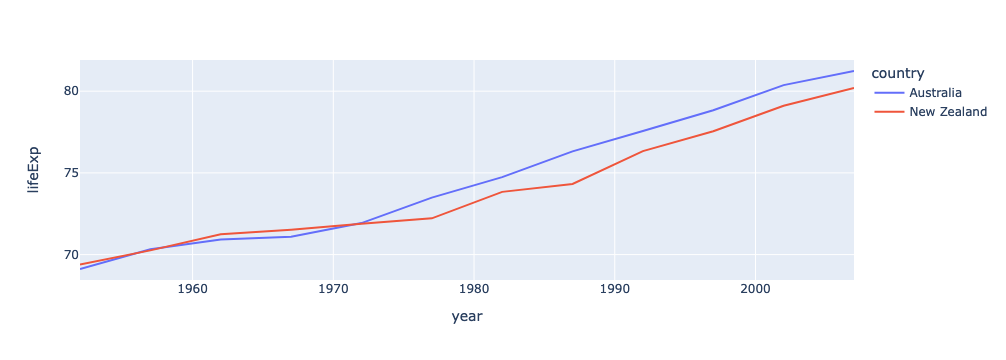

In [28]:
df = px.data.gapminder().query("continent=='Oceania'")
fig = px.line(df, x="year", y="lifeExp", color='country')
fig.show()



In [29]:
df

,country,continent,year,lifeExp,pop,gdpPercap,iso_alpha,iso_num
60,Australia,Oceania,1952,69.120,8691212,10039.59564,AUS,36
61,Australia,Oceania,1957,70.330,9712569,10949.64959,AUS,36
62,Australia,Oceania,1962,70.930,10794968,12217.22686,AUS,36
63,Australia,Oceania,1967,71.100,11872264,14526.12465,AUS,36
64,Australia,Oceania,1972,71.930,13177000,16788.62948,AUS,36
65,Australia,Oceania,1977,73.490,14074100,18334.19751,AUS,36
66,Australia,Oceania,1982,74.740,15184200,19477.00928,AUS,36
67,Australia,Oceania,1987,76.320,16257249,21888.88903,AUS,36
68,Australia,Oceania,1992,77.560,17481977,23424.76683,AUS,36
69,Australia,Oceania,1997,78.830,18565243,26997.93657,AUS,36


In [6]:
import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache

Plotting helper functions:

In [7]:
def imshow(tensor, renderer=None, xaxis="", yaxis="", **kwargs):
    px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=0.0, color_continuous_scale="RdBu", labels={"x":xaxis, "y":yaxis}, **kwargs).show(renderer)

def line(tensor, renderer=None, xaxis="", yaxis="", **kwargs):
    px.line(utils.to_numpy(tensor), labels={"x":xaxis, "y":yaxis}, **kwargs).show(renderer)

def scatter(x, y, xaxis="", yaxis="", caxis="", renderer=None, **kwargs):
    x = utils.to_numpy(x)
    y = utils.to_numpy(y)
    px.scatter(y=y, x=x, labels={"x":xaxis, "y":yaxis, "color":caxis}, **kwargs).show(renderer)

# Model Training

## Config

In [8]:
p = 53
frac_train = 0.5

# Optimizer config
lr = 1e-3
wd = 1. 
betas = (0.9, 0.98)

num_epochs = 50000
checkpoint_every = 100

In [9]:
53 ** 3

148877

## Define Task
* Define modular addition
* Define the dataset & labels

Input format:
|a|b|=|

In [10]:
# For p**4 elements add a d vector with l -> (i j k l)
a_vector = einops.repeat(torch.arange(p), "i -> (i j k)", j=p, k=p)
b_vector = einops.repeat(torch.arange(p), "j -> (i j k)", i=p, k=p)
c_vector = einops.repeat(torch.arange(p), "k -> (i j k)", i=p, j=p)
#d_vector = einops.repeat(torch.arange(p), "l -> (i j k l)", i=p, j=p, k=p) 
equals_vector = einops.repeat(torch.tensor(p), " -> (i j k)", i=p, j=p, k=p)
star_vector = einops.repeat(torch.tensor(p+1), " -> (i j k)", i=p, j=p, k=p)
plus_vector = einops.repeat(torch.tensor(p+2), " -> (i j k)", i=p, j=p, k=p)
#caret_vector = einops.repeat(torch.tensor(p+3), " -> (i j k l)", i=p, j=p, k=p, l=p)
#lparen = einops.repeat(torch.tensor(p+4), " -> (i j k l)", i=p, j=p, k=p, l=p)
#rparen = einops.repeat(torch.tensor(p+5), " -> (i j k l)", i=p, j=p, k=p, l=p)

In [11]:
# this ensures that the current MacOS version is at least 12.3+
print(torch.backends.mps.is_available())# this ensures that the current current PyTorch installation was built with MPS activated.
print(torch.backends.mps.is_built())

True
True


In [11]:
device = torch.device('mps')
dataset = torch.stack([
    a_vector,
    star_vector,
    b_vector,
    plus_vector,
    c_vector,
    equals_vector], dim=1)
print(dataset[:5])
print(dataset.shape)

tensor([[ 0, 54,  0, 55,  0, 53],
        [ 0, 54,  0, 55,  1, 53],
        [ 0, 54,  0, 55,  2, 53],
        [ 0, 54,  0, 55,  3, 53],
        [ 0, 54,  0, 55,  4, 53]])
torch.Size([148877, 6])


In [12]:
labels = ((dataset[:, 0] * dataset[:, 2] + dataset[:, 4])) % p
print(labels.shape)
print(labels[:5])

dataset = dataset.to(device)
labels = labels.to(device)

torch.Size([148877])
tensor([0, 1, 2, 3, 4])


In [13]:
from torch.utils.data import TensorDataset, DataLoader

Convert this to a train + test set - 30% in the training set

In [14]:
torch.manual_seed(314159)
indices = torch.randperm(p**4)
cutoff = int((p**4)*frac_train)
train_indices = indices[:cutoff]
test_indices = indices[cutoff:]

train_data = TensorDataset(dataset[train_indices], labels[train_indices])
test_data = TensorDataset(dataset[test_indices], labels[test_indices])
print(train_data[5])
#print(train_labels[:5])
#print(train_data.shape)
print(test_data[5])
#print(test_labels[:5])
#print(test_data.shape)

(tensor([37, 38, 39, 40, 41, 42], device='mps:0'), tensor(0, device='mps:0'))
(tensor([4645148,       0, 2860017,       0, 1182013,       0], device='mps:0'), tensor(6012116, device='mps:0'))


## Define Model

In [15]:

cfg = HookedTransformerConfig(
    n_layers = 1,
    n_heads = 4,
    d_model = 256,
    d_head = 64,
    d_mlp = 1024,
    act_fn = "relu",
    normalization_type=None,
    d_vocab=p+6,
    d_vocab_out=p,
    n_ctx=10,
    init_weights=True,
    device="cuda",
    seed = 999,
)

In [16]:
model = HookedTransformer(cfg)

Disable the biases, as we don't need them for this task.

In [17]:
for name, param in model.named_parameters():
    if "b_" in name:
        param.requires_grad = False


## Define Optimizer + Loss

In [18]:
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd, betas=betas)

In [15]:
def loss_fn(logits, labels):
    if len(logits.shape)==3:
        logits = logits[:, -1]
    logits = logits.to(torch.float64)
    log_probs = logits.log_softmax(dim=-1)
    correct_log_probs = log_probs.gather(dim=-1, index=labels[:, None])[:, 0]
    return -correct_log_probs.mean()

#train_logits = model(train_data)
#train_loss = loss_fn(train_logits, train_labels)
#print(train_loss)
#test_logits = model(test_data)
#test_loss = loss_fn(test_logits, test_labels)
#print(test_loss)

def train_forward(model, dataloader):
    total_loss = torch.tensor(0., device='cuda', requires_grad=False)
    for batch, labels in dataloader:
        logits = model(batch)
        loss = loss_fn(logits, labels)
        loss.backward()
        total_loss += loss
    return total_loss

def test_forward(model, dataloader):
    total_loss = torch.tensor(0., device='cuda', requires_grad=False)
    for batch, labels in dataloader:
        logits = model(batch)
        loss = loss_fn(logits, labels)
        total_loss += loss
    return total_loss

In [16]:
print("Uniform loss:")
print(np.log(p))

Uniform loss:
3.970291913552122


In [21]:
batch_size = 2 ** 16
batch_size

65536

In [22]:
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

## Actually Train

**Weird Decision:** Training the model with full batch training rather than stochastic gradient descent.

In [ ]:
train_losses = []
test_losses = []
model_checkpoints = []
checkpoint_epochs = []
num_epochs = 50_000
grok_threshold = 0.01

for epoch in tqdm.tqdm(range(num_epochs)):
    train_loss = train_forward(model, train_dataloader)
    train_losses.append(train_loss.item())

    optimizer.step()
    optimizer.zero_grad()

    with torch.inference_mode():
        test_loss = test_forward(model, train_dataloader)
        test_losses.append(test_loss.item())
    
    if (epoch % checkpoint_every) == 0:
        checkpoint_epochs.append(epoch)
        model_checkpoints.append(copy.deepcopy(model.state_dict()))
        print(f"Epoch {epoch} Train Loss {train_loss.item()} Test Loss {test_loss.item()}")
    if test_loss.item() <= grok_threshold:
        break

  0%|          | 0/50000 [00:00<?, ?it/s]

Epoch 0 Train Loss 242.78997802734375 Test Loss 237.64923095703125
Epoch 100 Train Loss 217.28501892089844 Test Loss 217.24752807617188
Epoch 200 Train Loss 209.68406677246094 Test Loss 209.5689697265625
Epoch 300 Train Loss 207.1466064453125 Test Loss 206.0689239501953
Epoch 400 Train Loss 204.72836303710938 Test Loss 204.74916076660156
Epoch 500 Train Loss 203.6313934326172 Test Loss 203.71217346191406
Epoch 600 Train Loss 202.8385772705078 Test Loss 202.80880737304688
Epoch 700 Train Loss 202.04086303710938 Test Loss 201.99293518066406
Epoch 800 Train Loss 201.083251953125 Test Loss 201.0811767578125
Epoch 900 Train Loss 200.2921142578125 Test Loss 200.03111267089844
Epoch 1000 Train Loss 199.1699676513672 Test Loss 199.12059020996094


In [ ]:
"""
num_epochs = 150_000
grok_threshold = 0.01

for epoch in tqdm.tqdm(range(num_epochs)):
    train_logits = model(train_data)
    train_loss = loss_fn(train_logits, train_labels)
    train_loss.backward()
    train_losses.append(train_loss.item())

    optimizer.step()
    optimizer.zero_grad()

    with torch.inference_mode():
        test_logits = model(test_data)
        test_loss = loss_fn(test_logits, test_labels)
        test_losses.append(test_loss.item())
    
    if ((epoch+1)%checkpoint_every)==0:
        checkpoint_epochs.append(epoch)
        model_checkpoints.append(copy.deepcopy(model.state_dict()))
        print(f"Epoch {epoch} Train Loss {train_loss.item()} Test Loss {test_loss.item()}")
    if test_loss.item() <= grok_threshold:
        break
"""

In [ ]:
torch.save(
     {
         "model":model.state_dict(),
         "config": model.cfg,
         "checkpoints": model_checkpoints,
         "checkpoint_epochs": checkpoint_epochs,
         "test_losses": test_losses,
         "train_losses": train_losses,
         "train_indices": train_indices,
         "test_indices": test_indices
     },
     "checkpoints/grokking_xyz_3333.pth")

## Show Model Training Statistics, Check that it groks!

In [17]:
saved_run = torch.load('grokking_xyz_3333.pth', map_location=torch.device('cpu'))
train_losses = saved_run['train_losses']
test_losses = saved_run['test_losses']
last_ckpt = saved_run['checkpoints'][-1]
config = saved_run['config']
config

HookedTransformerConfig:
{'act_fn': 'relu',
 'attention_dir': 'causal',
 'attn_only': False,
 'attn_types': None,
 'checkpoint_index': None,
 'checkpoint_label_type': None,
 'checkpoint_value': None,
 'd_head': 64,
 'd_mlp': 1024,
 'd_model': 256,
 'd_vocab': 57,
 'd_vocab_out': 53,
 'device': 'cuda',
 'eps': 1e-05,
 'final_rms': False,
 'from_checkpoint': False,
 'init_mode': 'gpt2',
 'init_weights': True,
 'initializer_range': 0.05,
 'model_name': 'custom',
 'n_ctx': 6,
 'n_heads': 4,
 'n_layers': 1,
 'n_params': 786432,
 'normalization_type': None,
 'original_architecture': None,
 'parallel_attn_mlp': False,
 'positional_embedding_type': 'standard',
 'rotary_dim': None,
 'scale_attn_by_inverse_layer_idx': False,
 'seed': 999,
 'tokenizer_name': None,
 'use_attn_result': False,
 'use_attn_scale': True,
 'use_local_attn': False,
 'window_size': None}

In [18]:
config.device = 'cpu'
model = HookedTransformer(config)
model.load_state_dict(last_ckpt)


<All keys matched successfully>

In [20]:
import polars as ps

In [27]:
['train'] * 5

['train', 'train', 'train', 'train', 'train']

In [36]:

traintest = (['train'] * len(train_losses))  + (['test'] * len(test_losses))
epochs = np.concatenate([np.arange(0, len(train_losses)), np.arange(0, len(test_losses))])
losses = np.array(train_losses + test_losses)
loss_data = ps.DataFrame({'epoch': epochs, 'loss': losses, 'split': traintest})


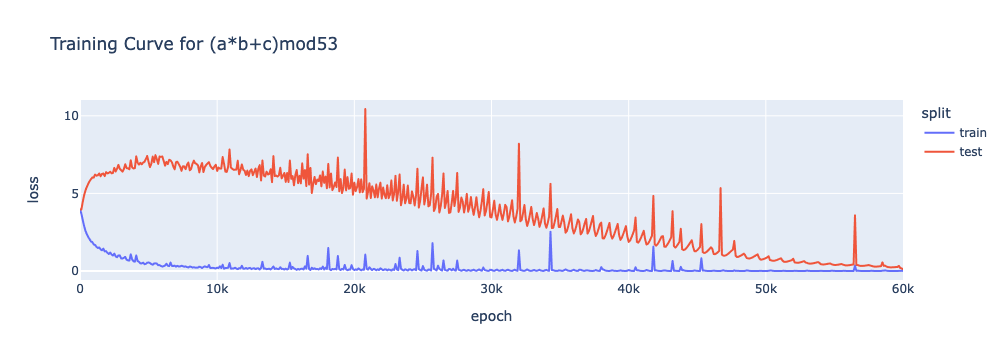

In [43]:
#loss_data
px.line(
    loss_data.filter(ps.col('epoch') % 100 == 0).to_pandas(),
    x='epoch', y='loss', color='split',
    title="Training Curve for (a*b+c)mod53")


# Analysing the Model

## Standard Things to Try

In [44]:
original_logits, cache = model.run_with_cache(dataset)
print(original_logits.numel())

47342886


Get key weight matrices:

In [45]:
W_E = model.embed.W_E[:-1]
print("W_E", W_E.shape)
W_neur = W_E @ model.blocks[0].attn.W_V @ model.blocks[0].attn.W_O @ model.blocks[0].mlp.W_in
print("W_neur", W_neur.shape)
W_logit = model.blocks[0].mlp.W_out @ model.unembed.W_U
print("W_logit", W_logit.shape)

W_E torch.Size([56, 256])
W_neur torch.Size([4, 56, 1024])
W_logit torch.Size([1024, 53])


In [46]:
#original_loss = loss_fn(original_logits, labels).item()
#print("Original Loss:", original_loss)

### Looking at Activations

Helper variable:

In [47]:
pattern_a = cache["pattern", 0, "attn"][:, :, -1, 0]
pattern_b = cache["pattern", 0, "attn"][:, :, -1, 1]
neuron_acts = cache["post", 0, "mlp"][:, -1, :]
neuron_pre_acts = cache["pre", 0, "mlp"][:, -1, :]

Get all shapes:

In [48]:
for param_name, param in cache.items():
    print(param_name, param.shape)

hook_embed torch.Size([148877, 6, 256])
hook_pos_embed torch.Size([148877, 6, 256])
blocks.0.hook_resid_pre torch.Size([148877, 6, 256])
blocks.0.attn.hook_q torch.Size([148877, 6, 4, 64])
blocks.0.attn.hook_k torch.Size([148877, 6, 4, 64])
blocks.0.attn.hook_v torch.Size([148877, 6, 4, 64])
blocks.0.attn.hook_attn_scores torch.Size([148877, 4, 6, 6])
blocks.0.attn.hook_pattern torch.Size([148877, 4, 6, 6])
blocks.0.attn.hook_z torch.Size([148877, 6, 4, 64])
blocks.0.hook_attn_out torch.Size([148877, 6, 256])
blocks.0.hook_resid_mid torch.Size([148877, 6, 256])
blocks.0.mlp.hook_pre torch.Size([148877, 6, 1024])
blocks.0.mlp.hook_post torch.Size([148877, 6, 1024])
blocks.0.hook_mlp_out torch.Size([148877, 6, 256])
blocks.0.hook_resid_post torch.Size([148877, 6, 256])


In [42]:
cache["pattern", 0].mean(dim=0)[:, -1, :]

tensor([[4.9950e-01, 7.3364e-07, 4.9976e-01, 3.3143e-13, 7.2308e-04, 1.1892e-05],
        [4.9945e-01, 7.9402e-07, 5.0004e-01, 5.8039e-06, 5.0061e-04, 2.3687e-06],
        [1.9856e-04, 6.2341e-06, 2.5696e-04, 2.2873e-05, 9.9951e-01, 1.3863e-06],
        [4.9869e-01, 2.6891e-07, 4.9689e-01, 3.4075e-03, 1.0081e-03, 1.6106e-06]])

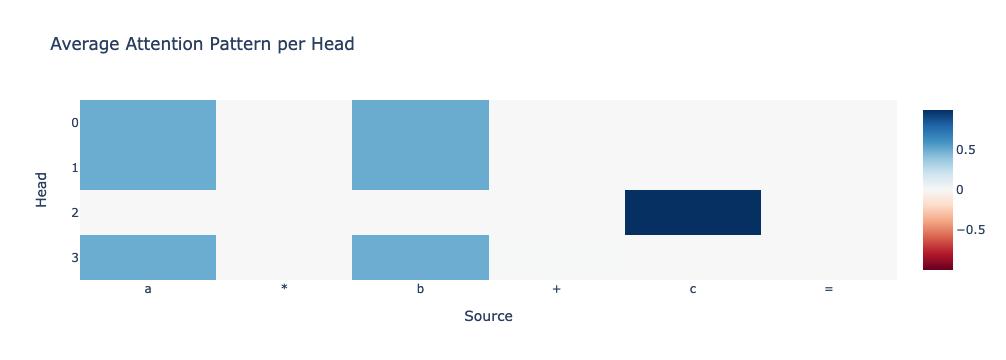

In [49]:
imshow(
    cache["pattern", 0].mean(dim=0)[:, -1, :],
    title="Average Attention Pattern per Head",
    xaxis="Source", yaxis="Head", x=['a', '*', 'b', '+', 'c', '='])

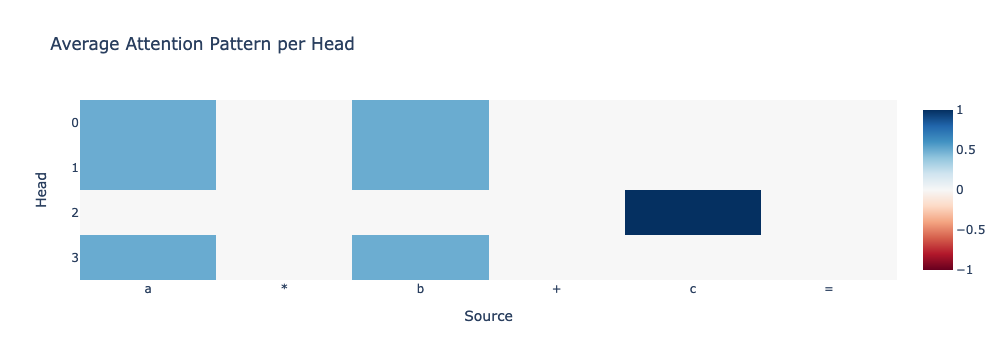

In [50]:
imshow(
    cache["pattern", 0][5][:, -1, :],
    title="Average Attention Pattern per Head",
    xaxis="Source",
    yaxis="Head",
    x=['a', '*', 'b', '+', 'c', '='])

In [56]:
cache["pattern", 0][:, 0, -1, 0].reshape(p, p, p).shape

torch.Size([53, 53, 53])

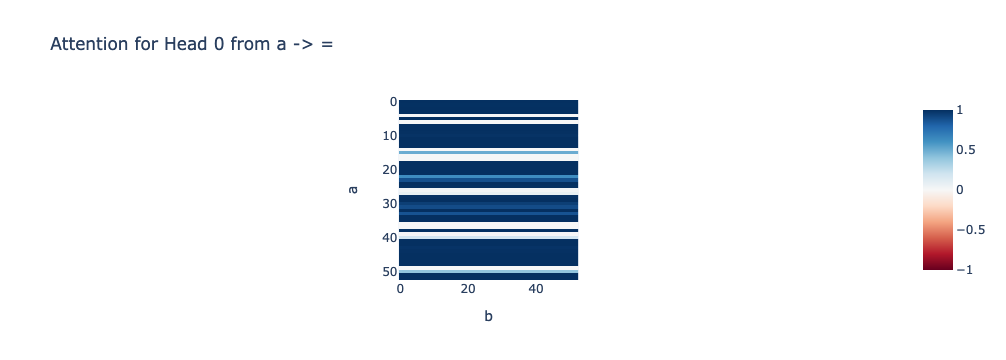

In [70]:
imshow(cache["pattern", 0][:, 0, -1, 0].reshape(p, p, p)[:, 15, :], title="Attention for Head 0 from a -> =", xaxis="b", yaxis="a")

In [ ]:
imshow(
    einops.rearrange(cache["pattern", 0][:, :, -1, 0], "(a b) head -> head a b c", a=p, b=p, c=p), 
    title="Attention for Head 0 from a -> =", xaxis="b", yaxis="a", facet_col=0)

Plotting neuron activations

In [71]:
cache["post", 0, "mlp"].shape

torch.Size([148877, 6, 1024])

In [ ]:
npx.imshow(
    einops.rearrange(neuron_acts[:, :5], "(a b c) neuron -> neuron a b c", a=p, b=p, c), 
    title="First 5 neuron acts", xaxis="b", yaxis="a", facet_col=0)

### Singular Value Decomposition

In [72]:
W_E.shape

torch.Size([56, 256])

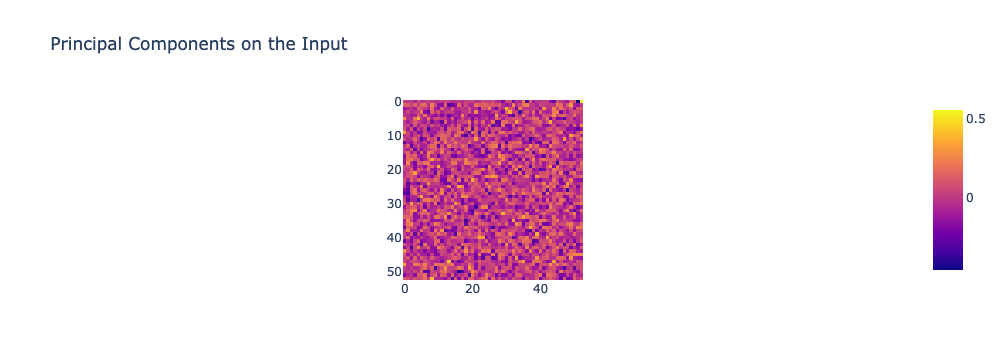

In [97]:
U, S, Vh = torch.svd(W_E[:53, :].detach())
px.line(S, title="Singular Values")
px.imshow(U, title="Principal Components on the Input")

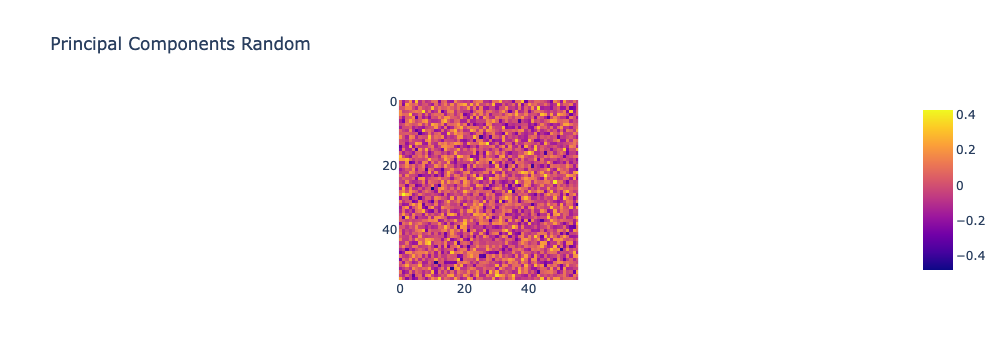

In [95]:
# Control - random Gaussian matrix
U, S, Vh = torch.svd(torch.randn_like(W_E))
px.line(S, title="Singular Values Random")
px.imshow(U, title="Principal Components Random")

## Explaining Algorithm

### Analyse the Embedding - It's a Lookup Table!

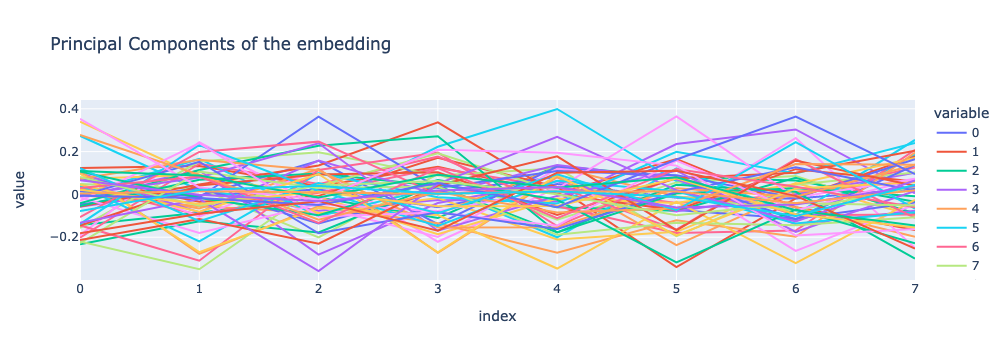

In [81]:
U, S, Vh = torch.svd(W_E)
line(U[:, :8].T, title="Principal Components of the embedding", xaxis="Input Vocabulary")

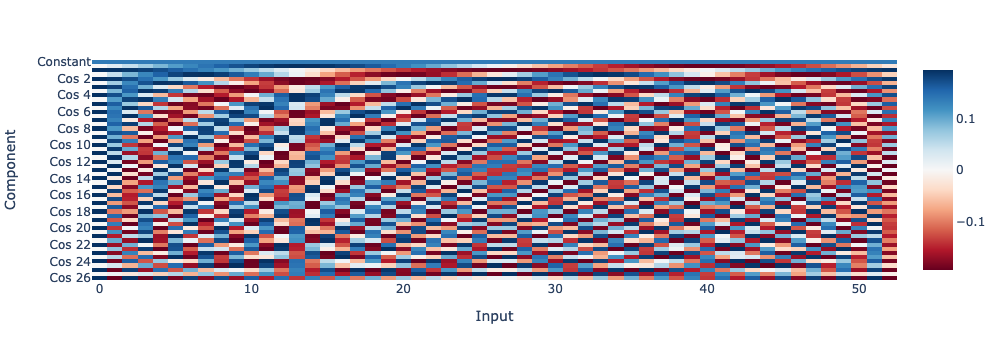

In [83]:
fourier_basis = []
fourier_basis_names = []
fourier_basis.append(torch.ones(p))
fourier_basis_names.append("Constant")
for freq in range(1, p//2+1):
    fourier_basis.append(torch.sin(torch.arange(p)*2 * torch.pi * freq / p))
    fourier_basis_names.append(f"Sin {freq}")
    fourier_basis.append(torch.cos(torch.arange(p)*2 * torch.pi * freq / p))
    fourier_basis_names.append(f"Cos {freq}")
fourier_basis = torch.stack(fourier_basis, dim=0)
fourier_basis = fourier_basis/fourier_basis.norm(dim=-1, keepdim=True)
imshow(fourier_basis, xaxis="Input", yaxis="Component", y=fourier_basis_names)

In [86]:
px.line(fourier_basis[:8], line_labels=fourier_basis_names[:8], title="First 8 Fourier Components")
px.line(fourier_basis[25:29], line_labels=fourier_basis_names[25:29], title="Middle Fourier Components")

TypeError: line() got an unexpected keyword argument 'line_labels'

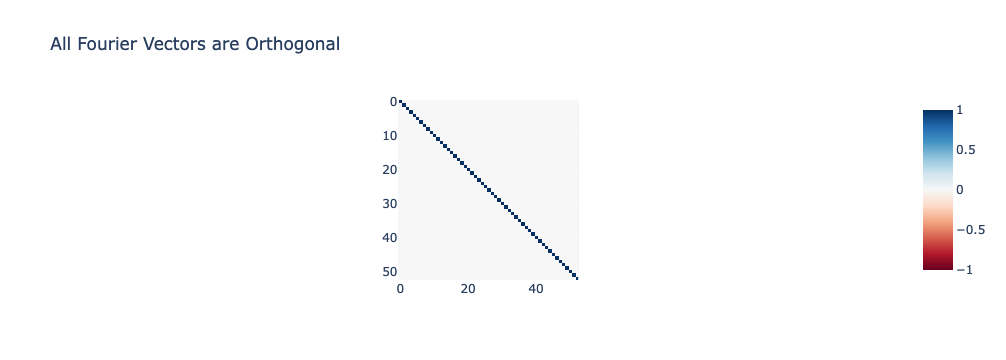

In [87]:
imshow(fourier_basis @ fourier_basis.T, title="All Fourier Vectors are Orthogonal")

In [91]:
W_E[:53,:].shape

torch.Size([53, 256])

### Analyse the Embedding

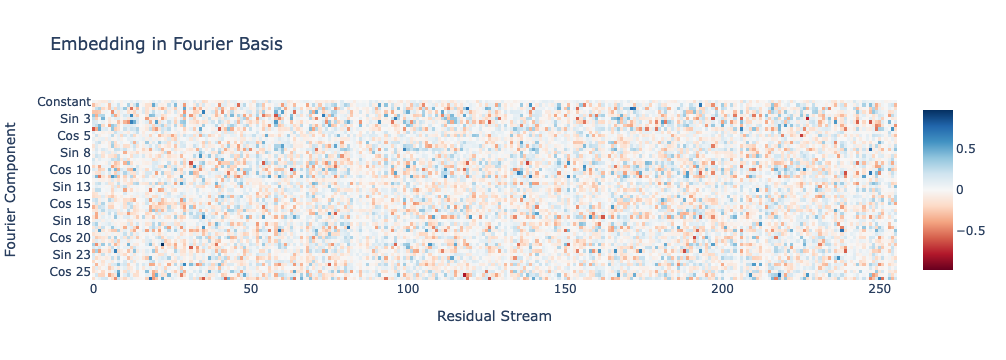

In [92]:
imshow(fourier_basis @ W_E[:53,:], yaxis="Fourier Component", xaxis="Residual Stream", y=fourier_basis_names, title="Embedding in Fourier Basis")

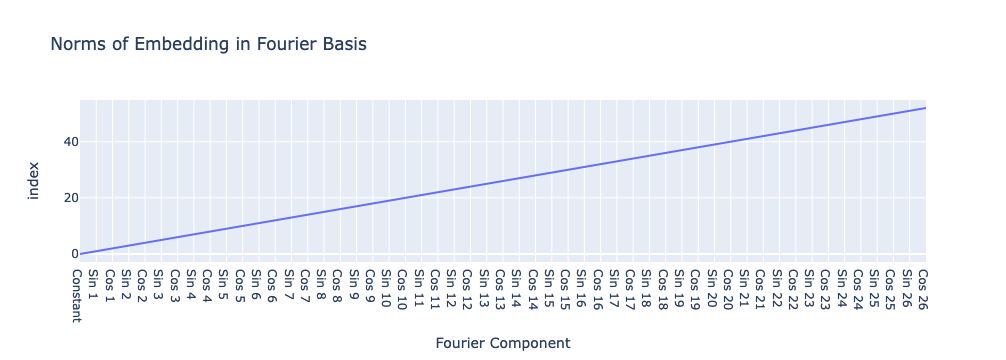

In [93]:
line((fourier_basis @ W_E[:53, :]).norm(dim=-1), xaxis="Fourier Component", x=fourier_basis_names, title="Norms of Embedding in Fourier Basis")

In [94]:
key_freqs = [17, 25, 32, 47]
key_freq_indices = [33, 34, 49, 50, 63, 64, 93, 94]
fourier_embed = fourier_basis @ W_E[:53, :]
key_fourier_embed = fourier_embed[key_freq_indices]
print("key_fourier_embed", key_fourier_embed.shape)
npx.imshow(key_fourier_embed @ key_fourier_embed.T, title="Dot Product of embedding of key Fourier Terms")

IndexError: index 63 is out of bounds for dimension 0 with size 53

### Key Frequencies

In [ ]:
line(fourier_basis[[34, 50, 64, 94]], title="Cos of key freqs", line_labels=[34, 50, 64, 94])

In [ ]:
line(fourier_basis[[34, 50, 64, 94]].mean(0), title="Constructive Interference")

## Analyse Neurons

In [ ]:
imshow(
    einops.rearrange(neuron_acts[:, :5], "(a b) neuron -> neuron a b", a=p, b=p), 
    title="First 5 neuron acts", xaxis="b", yaxis="a", facet_col=0)

In [ ]:
imshow(
    einops.rearrange(neuron_acts[:, 0], "(a b) -> a b", a=p, b=p), 
    title="First neuron act", xaxis="b", yaxis="a",)

In [ ]:
imshow(fourier_basis[94][None, :] * fourier_basis[94][:, None], title="Cos 47a * cos 47b")

In [ ]:
imshow(fourier_basis[94][None, :] * fourier_basis[0][:, None], title="Cos 47a * const")

In [ ]:
imshow(fourier_basis @ neuron_acts[:, 0].reshape(p, p) @ fourier_basis.T, title="2D Fourier Transformer of neuron 0", xaxis="b", yaxis="a", x=fourier_basis_names, y=fourier_basis_names)

In [ ]:
imshow(fourier_basis @ neuron_acts[:, 5].reshape(p, p) @ fourier_basis.T, title="2D Fourier Transformer of neuron 5", xaxis="b", yaxis="a", x=fourier_basis_names, y=fourier_basis_names)

In [ ]:
imshow(fourier_basis @ torch.randn_like(neuron_acts[:, 0]).reshape(p, p) @ fourier_basis.T, title="2D Fourier Transformer of RANDOM", xaxis="b", yaxis="a", x=fourier_basis_names, y=fourier_basis_names)

### Neuron Clusters

In [ ]:
fourier_neuron_acts = fourier_basis @ einops.rearrange(neuron_acts, "(a b) neuron -> neuron a b", a=p, b=p) @ fourier_basis.T
# Center these by removing the mean - doesn't matter!
fourier_neuron_acts[:, 0, 0] = 0.
print("fourier_neuron_acts", fourier_neuron_acts.shape)

In [ ]:
neuron_freq_norm = torch.zeros(p//2, model.cfg.d_mlp).cuda()
for freq in range(0, p//2):
    for x in [0, 2*(freq+1) - 1, 2*(freq+1)]:
        for y in [0, 2*(freq+1) - 1, 2*(freq+1)]:
            neuron_freq_norm[freq] += fourier_neuron_acts[:, x, y]**2
neuron_freq_norm = neuron_freq_norm / fourier_neuron_acts.pow(2).sum(dim=[-1, -2])[None, :]
npx.imshow(neuron_freq_norm, xaxis="Neuron", yaxis="Freq", y=torch.arange(1, p//2+1), title="Neuron Frac Explained by Freq")

In [ ]:
npx.line(neuron_freq_norm.max(dim=0).values.sort().values, xaxis="Neuron", title="Max Neuron Frac Explained over Freqs")

## Read Off the Neuron-Logit Weights to Interpret

In [ ]:
W_logit = model.blocks[0].mlp.W_out @ model.unembed.W_U
print("W_logit", W_logit.shape)

In [ ]:
npx.line((W_logit @ fourier_basis.T).norm(dim=0), x=fourier_basis_names, title="W_logit in the Fourier Basis")

In [ ]:
neurons_17 = neuron_freq_norm[17-1]>0.85
neurons_17.shape

In [ ]:
neurons_17.sum()

In [ ]:
npx.line((W_logit[neurons_17] @ fourier_basis.T).norm(dim=0), x=fourier_basis_names, title="W_logit for freq 17 neurons in the Fourier Basis")

Study sin 17

In [ ]:
freq = 17
W_logit_fourier = W_logit @ fourier_basis
neurons_sin_17 = W_logit_fourier[:, 2*freq-1]
npx.line(neurons_sin_17)

In [ ]:
neuron_acts.shape

In [ ]:
inputs_sin_17c = neuron_acts @ neurons_sin_17
npx.imshow(fourier_basis @ inputs_sin_17c.reshape(p, p) @ fourier_basis.T, title="Fourier Heatmap over inputs for sin17c", x=fourier_basis_names, y=fourier_basis_names)

# Black Box Methods + Progress Measures